## Pre-reqs:
Run `pip install -r requirements.txt` in the command line first.

## Creating the dataset

We will generate 1000 random observations of sounds. For each sound observation, we will randomly generate a direction and a distance, and then compute the signed time difference between the time that the sound arrives at the left ear and the right ear.

In [109]:
import random
import math

random.seed(42)

class SoundMaker:
    def __init__(self, head_radius, speed_of_sound=300, min_distance=5, max_distance=500):
        self.head_radius = head_radius
        self.speed_of_sound = speed_of_sound
        self.min_distance = min_distance
        self.max_distance = max_distance

    def generate_random_coordinates(self):
        # the randomness is uniform over direction and distance
        angle = random.uniform(0, 2 * math.pi)
        distance = random.uniform(self.min_distance, self.max_distance)
        y = distance * math.sin(angle)
        x = math.sqrt(distance**2 - y**2) * (-1)**(math.pi/2 < angle < 3/2 *math.pi)
        return (x, y)

    def make_sound_from_coordinates(self, x, y):
        distance = math.sqrt(x**2 + y**2)
        distance_left = math.sqrt(y**2+(x-self.head_radius)**2)
        distance_right = math.sqrt(y**2+(x+self.head_radius)**2)
        dt = (distance_left - distance_right)/self.speed_of_sound
        angle = math.atan2(y, x)
        if angle < 0:
            # shift range from (-pi, pi) to (0, 2 pi) since ReLU is positive
            angle += 2*math.pi
        return dt, distance, angle

    def make_sound(self):
        x, y = self.generate_random_coordinates()
        return self.make_sound_from_coordinates(x, y)

soundMaker = SoundMaker(0.1)

## Baseline using MLP
Let's first train a classical MLP and see how it performs. First we build a MLP.

In [110]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        
        # Create input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        
        # Create hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        
        # Create output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # Initialize weights
        for layer in self.layers:
            nn.init.normal_(layer.weight, mean=0, std=0.01)
            nn.init.normal_(layer.bias, mean=0, std=0.01)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.leaky_relu(layer(x))
        x = self.layers[-1](x)
        return x

# Example usage
input_size = 1
hidden_sizes = [5, 5]
output_size = 1

mlp = MLP(input_size, hidden_sizes, output_size)

# Print the model architecture
print(mlp)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=5, bias=True)
    (2): Linear(in_features=5, out_features=1, bias=True)
  )
)


We then proceed to train it. Feel free to skip this part until we get to the results.

We begin with wrapping our dataset and feed it into a dataloader

In [111]:
from torch.utils.data import Dataset

# wrapper for our dataset
class CustomDataset(Dataset):
    def __init__(self, train=True):
        if train:
            self.dataset_length = 500
        else:
            self.dataset_length = 500

    def __len__(self):
        # return len(self.inputs)
        # since we generate data on the fly, we 'say' that our dataset has a length of 500
        return self.dataset_length

    def __getitem__(self, idx):
        dt, distance, angle = soundMaker.make_sound()
        # The inputs are the time difference (dt) and the outputs are the direction (measured from the positive x-axis)
        inputs = torch.tensor([dt], dtype=torch.float32)
        targets = torch.tensor([angle], dtype=torch.float32)
        return inputs, targets

train_dataset = CustomDataset(train=True)
test_dataset = CustomDataset(train=False)

In [112]:
from torch.utils.data import DataLoader

# feed into dataloader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Now we define the training routine

In [120]:
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generated_angles = []

def train(model, title="MLP", epochs=20, loss_fn=nn.MSELoss()):
    optimizer = optim.SGD(mlp.parameters(), lr=1e-2, weight_decay=1e-3)
    # optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
    train_loss_all = []
    val_loss_all = []
    losses = []
    for epoch in range(epochs):
        # Train
        train_loss = 0
        train_num = 0
        model.train()
        with tqdm(train_loader) as pbar:
            running_loss = 0.0
            for input, target in pbar:
                input = input.view(-1, 1).to(device)
                optimizer.zero_grad()
                output = model(input)
                loss = loss_fn(output, target.to(device))
                generated_angles.append(target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()*input.size(0)
                train_num += input.size(0)
                pbar.set_postfix(lr=optimizer.param_groups[0]['lr'])
        print('Epoch %d, Train loss: %.3f' % (epoch + 1, train_loss/train_num))
        train_loss_all.append(train_loss/train_num)
        pbar.set_postfix(loss=train_loss/train_num)
    
        # Validation
        mlp.eval()
        val_loss = 0
        val_accuracy = 0
        val_num = 0
        with torch.no_grad():
            for input, target in test_loader:
                input = input.view(-1, 1).to(device)
                output = model(input)
                val_loss += loss_fn(output, target.to(device)).item()*input.size(0)
                val_num += input.size(0)
        val_loss_all.append(val_loss/val_num)
        # val_accuracy /= len(valloader)
    
        # Update learning rate
        # scheduler.step()
    
        print(
            f"Epoch {epoch + 1}, Val Loss: {val_loss/val_num}"
        )
    # Plot the loss values against the number of epochs
    fig, ax = plt.subplots()
    ax.plot(range(1, epoch + 2), train_loss_all, label='Train Loss')
    ax.plot(range(1, epoch + 2), val_loss_all, label='Val Loss')
    ax.set_title(f'Loss Curves {title}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()

Finally, let's train it

100%|█████████████████████████████████| 63/63 [00:00<00:00, 112.58it/s, lr=0.01]


Epoch 1, Train loss: 7.147
Epoch 1, Val Loss: 3.755388666152954


100%|█████████████████████████████████| 63/63 [00:00<00:00, 112.20it/s, lr=0.01]


Epoch 2, Train loss: 3.622
Epoch 2, Val Loss: 3.121619094848633


100%|█████████████████████████████████| 63/63 [00:00<00:00, 159.09it/s, lr=0.01]


Epoch 3, Train loss: 3.104
Epoch 3, Val Loss: 3.4467387886047365


100%|█████████████████████████████████| 63/63 [00:00<00:00, 104.00it/s, lr=0.01]


Epoch 4, Train loss: 3.328
Epoch 4, Val Loss: 3.0911970500946047


100%|█████████████████████████████████| 63/63 [00:00<00:00, 139.82it/s, lr=0.01]


Epoch 5, Train loss: 3.446
Epoch 5, Val Loss: 3.1024200534820556


100%|█████████████████████████████████| 63/63 [00:00<00:00, 134.90it/s, lr=0.01]


Epoch 6, Train loss: 3.369
Epoch 6, Val Loss: 3.156308819770813


100%|█████████████████████████████████| 63/63 [00:00<00:00, 119.51it/s, lr=0.01]


Epoch 7, Train loss: 3.409
Epoch 7, Val Loss: 3.28905948638916


100%|█████████████████████████████████| 63/63 [00:00<00:00, 129.70it/s, lr=0.01]


Epoch 8, Train loss: 3.546
Epoch 8, Val Loss: 3.3935077753067016


100%|█████████████████████████████████| 63/63 [00:00<00:00, 125.38it/s, lr=0.01]


Epoch 9, Train loss: 3.448
Epoch 9, Val Loss: 3.43611171913147


100%|█████████████████████████████████| 63/63 [00:00<00:00, 117.60it/s, lr=0.01]


Epoch 10, Train loss: 3.259
Epoch 10, Val Loss: 3.248594068527222


100%|█████████████████████████████████| 63/63 [00:00<00:00, 103.91it/s, lr=0.01]


Epoch 11, Train loss: 3.297
Epoch 11, Val Loss: 3.2283342361450194


100%|█████████████████████████████████| 63/63 [00:00<00:00, 131.81it/s, lr=0.01]


Epoch 12, Train loss: 3.582
Epoch 12, Val Loss: 3.333595199584961


100%|█████████████████████████████████| 63/63 [00:00<00:00, 110.45it/s, lr=0.01]


Epoch 13, Train loss: 3.210
Epoch 13, Val Loss: 2.9501694288253786


100%|█████████████████████████████████| 63/63 [00:00<00:00, 112.97it/s, lr=0.01]


Epoch 14, Train loss: 3.213
Epoch 14, Val Loss: 3.3117910766601564


100%|█████████████████████████████████| 63/63 [00:00<00:00, 121.64it/s, lr=0.01]


Epoch 15, Train loss: 3.303
Epoch 15, Val Loss: 3.301529504776001


100%|█████████████████████████████████| 63/63 [00:00<00:00, 166.68it/s, lr=0.01]


Epoch 16, Train loss: 3.350
Epoch 16, Val Loss: 3.2685412664413453


100%|█████████████████████████████████| 63/63 [00:00<00:00, 139.61it/s, lr=0.01]


Epoch 17, Train loss: 3.561
Epoch 17, Val Loss: 3.0193252010345457


100%|█████████████████████████████████| 63/63 [00:00<00:00, 136.76it/s, lr=0.01]


Epoch 18, Train loss: 3.182
Epoch 18, Val Loss: 3.29041606092453


100%|█████████████████████████████████| 63/63 [00:00<00:00, 132.36it/s, lr=0.01]


Epoch 19, Train loss: 3.100
Epoch 19, Val Loss: 3.430278745651245


100%|█████████████████████████████████| 63/63 [00:00<00:00, 132.29it/s, lr=0.01]


Epoch 20, Train loss: 3.561
Epoch 20, Val Loss: 3.313218988418579


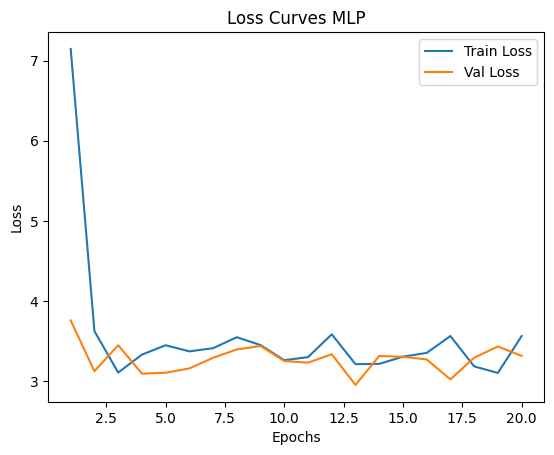

In [114]:
train(mlp, "MLP")

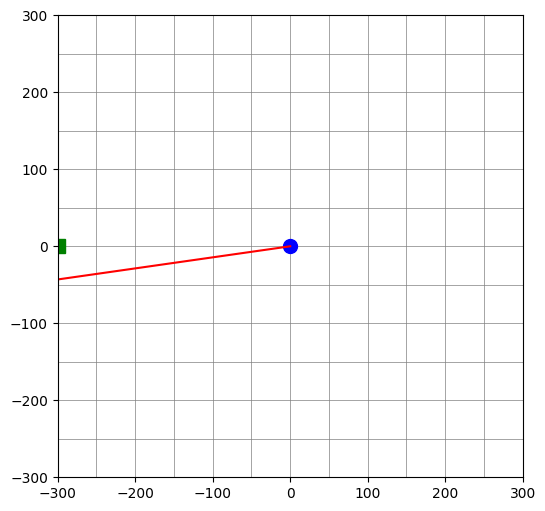

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

# Define the size of the grid
grid_size = 600

# Initial position of the agent (center of the grid)
agent_x, agent_y = 0, 0

# Define the respond function (black box)
def respond(x, y):
    # For the sake of example, let's return a fixed direction
    # In a real scenario, this would be replaced by the actual black box function logic
    # return 45  # Returning 45 degrees as the direction
    dt, distance, azimuth = soundMaker.make_sound_from_coordinates(x, y)
    with torch.no_grad():
        input = torch.tensor([[dt]])
        output = mlp(input)
    return output[0].item()

# Function to draw the grid, agent, and user input
def draw_grid(agent_x, agent_y, user_x, user_y, ax):
    ax.clear()
    ax.set_xlim(-grid_size // 2, grid_size // 2)
    ax.set_ylim(-grid_size // 2, grid_size // 2)
    
    # Draw grid lines
    step = 50  # Step size for the grid lines
    for i in range(-grid_size // 2, grid_size // 2 + step, step):
        ax.axhline(i, color='gray', linewidth=0.5)
        ax.axvline(i, color='gray', linewidth=0.5)
    
    # Draw the agent
    ax.plot(agent_x, agent_y, 'bo', markersize=10)  # Blue circle for the agent
    
    # Draw the user input point
    ax.plot(user_x, user_y, 'gs', markersize=10)  # Green square for the user input

# Function to draw the laser direction
def draw_laser(ax, x, y, angle):
    # Calculate the end point of the laser
    laser_length = grid_size  # Set the laser length to be the size of the grid
    end_x = x + laser_length * np.cos(angle)
    end_y = y + laser_length * np.sin(angle)
    
    # Draw the laser
    ax.plot([x, end_x], [y, end_y], 'r-')

# Function to animate the agent shooting the laser at the given direction and user input
def animate(i):
    user_x, user_y = user_inputs[i]
    angle = respond(user_x, user_y)
    draw_grid(agent_x, agent_y, user_x, user_y, ax)
    draw_laser(ax, agent_x, agent_y, angle)

# List of user inputs
user_inputs = [(100, 200), (-100, -200), (150, 50), (-150, -50), (300, 0), (-300, 0)]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=len(user_inputs), interval=500, repeat=False)

# Save the animation as a video file (optional)
ani.save('agent_laser_animation.mp4', writer='ffmpeg')

# Display the animation
plt.show()


In [119]:
dt, distance, azimuth = soundMaker.make_sound()
with torch.no_grad():
    input = torch.tensor([[dt]])
    output = mlp(input)
print(dt, output[0].item())

0.00020943643344821793 3.2842633724212646


In [141]:
class AngleLoss(nn.Module):
    def __init__(self):
        super(AngleLoss, self).__init__()

    def forward(self, input, target):
        # Calculate the squared difference
        diff = input - target
        scaled = (diff/math.pi) ** 2 * math.pi/2
        loss = torch.sin(scaled)
        return loss.mean()

In [142]:
# Example usage
input_size = 1
hidden_sizes = [5, 5]
output_size = 1

mlp2 = MLP(input_size, hidden_sizes, output_size)

100%|█████████████████████████████████| 63/63 [00:00<00:00, 125.45it/s, lr=0.01]


Epoch 1, Train loss: 0.185
Epoch 1, Val Loss: 12.495445587158203


100%|█████████████████████████████████| 63/63 [00:00<00:00, 132.30it/s, lr=0.01]


Epoch 2, Train loss: 0.145
Epoch 2, Val Loss: 13.368010482788087


100%|█████████████████████████████████| 63/63 [00:00<00:00, 147.10it/s, lr=0.01]


Epoch 3, Train loss: 0.168
Epoch 3, Val Loss: 12.533994178771973


100%|██████████████████████████████████| 63/63 [00:00<00:00, 80.35it/s, lr=0.01]


Epoch 4, Train loss: 0.248
Epoch 4, Val Loss: 13.01057472229004


100%|█████████████████████████████████| 63/63 [00:00<00:00, 141.36it/s, lr=0.01]


Epoch 5, Train loss: 0.190
Epoch 5, Val Loss: 13.129698360443115


100%|█████████████████████████████████| 63/63 [00:00<00:00, 154.52it/s, lr=0.01]


Epoch 6, Train loss: 0.171
Epoch 6, Val Loss: 12.196413833618164


100%|█████████████████████████████████| 63/63 [00:00<00:00, 116.98it/s, lr=0.01]


Epoch 7, Train loss: 0.184
Epoch 7, Val Loss: 12.084120140075683


100%|█████████████████████████████████| 63/63 [00:00<00:00, 157.47it/s, lr=0.01]


Epoch 8, Train loss: 0.153
Epoch 8, Val Loss: 12.72158253479004


100%|█████████████████████████████████| 63/63 [00:00<00:00, 160.74it/s, lr=0.01]


Epoch 9, Train loss: 0.212
Epoch 9, Val Loss: 13.54610945892334


100%|█████████████████████████████████| 63/63 [00:00<00:00, 155.95it/s, lr=0.01]


Epoch 10, Train loss: 0.166
Epoch 10, Val Loss: 13.367094856262208


100%|█████████████████████████████████| 63/63 [00:00<00:00, 158.12it/s, lr=0.01]


Epoch 11, Train loss: 0.176
Epoch 11, Val Loss: 13.31311890411377


100%|██████████████████████████████████| 63/63 [00:00<00:00, 99.21it/s, lr=0.01]


Epoch 12, Train loss: 0.182
Epoch 12, Val Loss: 13.383533351898194


100%|█████████████████████████████████| 63/63 [00:00<00:00, 147.73it/s, lr=0.01]


Epoch 13, Train loss: 0.181
Epoch 13, Val Loss: 13.67586222076416


100%|█████████████████████████████████| 63/63 [00:00<00:00, 137.89it/s, lr=0.01]


Epoch 14, Train loss: 0.186
Epoch 14, Val Loss: 12.81517133140564


100%|█████████████████████████████████| 63/63 [00:00<00:00, 150.82it/s, lr=0.01]


Epoch 15, Train loss: 0.205
Epoch 15, Val Loss: 13.020503067016602


100%|█████████████████████████████████| 63/63 [00:00<00:00, 131.21it/s, lr=0.01]


Epoch 16, Train loss: 0.145
Epoch 16, Val Loss: 12.971619483947753


100%|█████████████████████████████████| 63/63 [00:00<00:00, 112.98it/s, lr=0.01]


Epoch 17, Train loss: 0.216
Epoch 17, Val Loss: 13.125394332885742


100%|█████████████████████████████████| 63/63 [00:00<00:00, 163.56it/s, lr=0.01]


Epoch 18, Train loss: 0.140
Epoch 18, Val Loss: 12.959958572387695


100%|█████████████████████████████████| 63/63 [00:00<00:00, 151.68it/s, lr=0.01]


Epoch 19, Train loss: 0.162
Epoch 19, Val Loss: 12.611669563293457


100%|█████████████████████████████████| 63/63 [00:00<00:00, 119.78it/s, lr=0.01]


Epoch 20, Train loss: 0.154
Epoch 20, Val Loss: 12.51593397140503


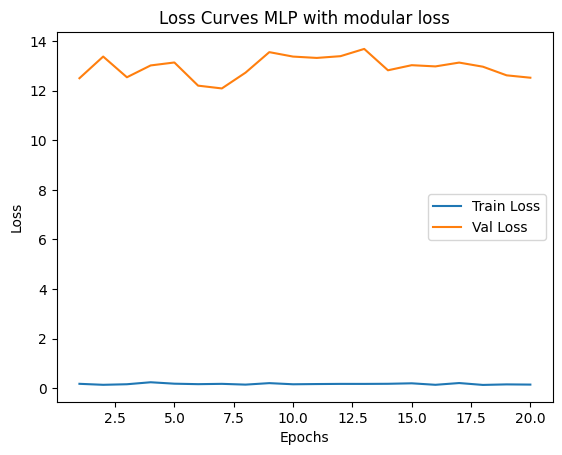

In [143]:
train(mlp2, "MLP with modular loss", loss_fn=AngleLoss())

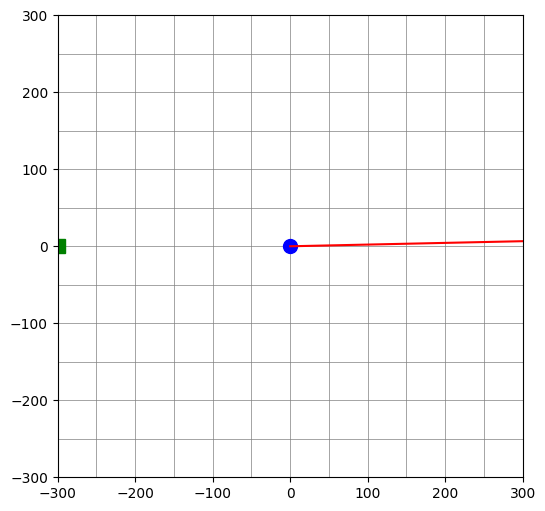

In [147]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

# Define the size of the grid
grid_size = 600

# Initial position of the agent (center of the grid)
agent_x, agent_y = 0, 0

# Define the respond function (black box)
def respond(x, y):
    # For the sake of example, let's return a fixed direction
    # In a real scenario, this would be replaced by the actual black box function logic
    dt, distance, azimuth = soundMaker.make_sound_from_coordinates(x, y)
    with torch.no_grad():
        input = torch.tensor([[dt]])
        output = mlp2(input)
    return output[0].item()

# Function to draw the grid, agent, and user input
def draw_grid(agent_x, agent_y, user_x, user_y, ax):
    ax.clear()
    ax.set_xlim(-grid_size // 2, grid_size // 2)
    ax.set_ylim(-grid_size // 2, grid_size // 2)
    
    # Draw grid lines
    step = 50  # Step size for the grid lines
    for i in range(-grid_size // 2, grid_size // 2 + step, step):
        ax.axhline(i, color='gray', linewidth=0.5)
        ax.axvline(i, color='gray', linewidth=0.5)
    
    # Draw the agent
    ax.plot(agent_x, agent_y, 'bo', markersize=10)  # Blue circle for the agent
    
    # Draw the user input point
    ax.plot(user_x, user_y, 'gs', markersize=10)  # Green square for the user input

# Function to draw the laser direction
def draw_laser(ax, x, y, angle):
    # Calculate the end point of the laser
    laser_length = grid_size  # Set the laser length to be the size of the grid
    end_x = x + laser_length * np.cos(angle)
    end_y = y + laser_length * np.sin(angle)
    
    # Draw the laser
    ax.plot([x, end_x], [y, end_y], 'r-')

# Function to animate the agent shooting the laser at the given direction and user input
def animate(i):
    user_x, user_y = user_inputs[i]
    angle = respond(user_x, user_y)
    draw_grid(agent_x, agent_y, user_x, user_y, ax)
    draw_laser(ax, agent_x, agent_y, angle)

# List of user inputs
user_inputs = [(100, 200), (-100, -200), (150, 50), (-150, -50), (300, 0), (-300, 0)]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=len(user_inputs), interval=500, repeat=False)

# Save the animation as a video file (optional)
ani.save('agent_laser_animation.mp4', writer='ffmpeg')

# Display the animation
plt.show()
